In [352]:
from torchvision import datasets, transforms
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

### Read MNIST

In [312]:
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ]))

### Model

In [313]:
class Model(nn.Module):
    def __init__(self, feature_dim=784, hidden1_dim=128, hidden2_dim=128, output_dim=10):
        super(Model, self).__init__()
        self.feature_dim = feature_dim
        self.fc1 = nn.Linear(feature_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.fc3 = nn.Linear(hidden2_dim, output_dim)
    
    def forward(self, x):
        x = x.view(-1, self.feature_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [314]:
model = Model()

### Training loop

In [317]:
def train(model, dataset, epochs=100):
    losses = []
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    loss = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for idx, (inputs, targets) in enumerate(dataloader):
            predictions = model(inputs)
            L = loss(predictions, targets)
            losses.append(L)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
        print('Epoch', str(_)+':', 'loss:', L.item())
    return L

In [318]:
losses = train(model, train_dataset, epochs=50)

Epoch 0: loss: 0.15730540454387665
Epoch 1: loss: 0.10281114280223846
Epoch 2: loss: 0.24305333197116852
Epoch 3: loss: 0.24171625077724457
Epoch 4: loss: 0.11638514697551727
Epoch 5: loss: 0.025170406326651573
Epoch 6: loss: 0.1361529678106308
Epoch 7: loss: 0.14385291934013367
Epoch 8: loss: 0.3532721698284149
Epoch 9: loss: 0.16745327413082123
Epoch 10: loss: 0.039212167263031006
Epoch 11: loss: 0.008246148936450481
Epoch 12: loss: 0.0482584685087204
Epoch 13: loss: 0.023358361795544624
Epoch 14: loss: 0.08123832941055298
Epoch 15: loss: 0.016502724960446358
Epoch 16: loss: 0.03337829187512398
Epoch 17: loss: 0.06547430157661438
Epoch 18: loss: 0.07699750363826752
Epoch 19: loss: 0.02370930276811123
Epoch 20: loss: 0.02289646863937378
Epoch 21: loss: 0.008833952248096466
Epoch 22: loss: 0.00245304754935205
Epoch 23: loss: 0.13975133001804352
Epoch 24: loss: 0.019026288762688637
Epoch 25: loss: 0.028896763920783997
Epoch 26: loss: 0.007468723226338625
Epoch 27: loss: 0.16399416327476

### Accuracy check on test samples

In [319]:
def measure_accuracy(model, dataset):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    correct = 0
    count = 0
    for data in dataloader:
        inputs, targets = data
        count += len(inputs)
        with torch.no_grad():
            prediction = model(inputs).max(dim=1)[1]
        correct += torch.sum(prediction == targets).item()
    return correct / count

In [361]:
print('model accuracy:', measure_accuracy(model, test_dataset))

model accuracy: 0.9747


### Fast gradient sign method

In [362]:
def attack(sample, grad, eps):
    spoiled_sample = sample + eps * grad.sign()
    return torch.clamp(spoiled_sample, 0, 1)

def test_attack(model, dataset, eps, epochs=50):
    loss = nn.CrossEntropyLoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    count = 0
    correct = 0
    examples = []
    for data, target in dataloader:
        count += 1
        data.requires_grad = True
        true_prediction = model(data)
        
        if true_prediction.max(dim=1, keepdims=True)[1].item() != target.item():
            continue
            
        L = loss(true_prediction, target)
        model.zero_grad()
        L.backward()
        spoiled_data = attack(data, data.grad.data, eps)
        fake_prediction = model(spoiled_data).max(dim=1, keepdims=True)[1]
        if fake_prediction == target:
            correct += 1
        else:
            examples.append(spoiled_data)
    return torch.cat(examples), correct / count

In [363]:
eps = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]
for e in eps:
    print('eps:', str(e)+',', 'accuracy:', test_attack(model, test_dataset, e)[1])

eps: 0.01, accuracy: 0.9219
eps: 0.02, accuracy: 0.7604
eps: 0.03, accuracy: 0.5118
eps: 0.04, accuracy: 0.3307
eps: 0.05, accuracy: 0.2324
eps: 0.1, accuracy: 0.0477
eps: 0.15, accuracy: 0.0091
eps: 0.2, accuracy: 0.0026


In [368]:
examples = test_attack(model, test_dataset, 0.03)[0]

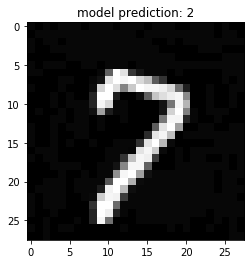

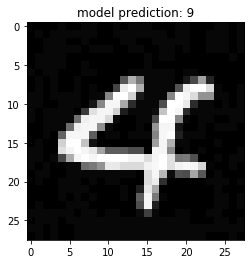

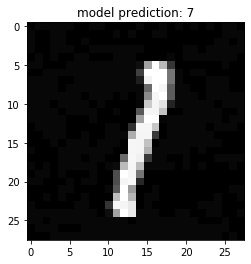

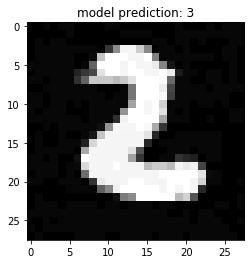

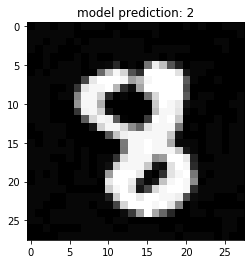

In [369]:
rand_examples = np.random.randint(low=0, high=len(examples)-1, size=(5, ))
for i in rand_examples:
    prediction = model(examples[i]).max(dim=1)[1].item()
    plt.imshow(examples[i].detach().numpy()[0], cmap='gray')
    plt.title(f'model prediction: {prediction}')
    plt.show()